## Visualizing the Model Predictions

#### Primary Goal: Visualize and inspect the model predictions 
In this notebook, I'll brief tutorial for making 2D visualizations of the ML model predictions. 

In [141]:
# Import packages 
import pandas as pd
import numpy as np
import netCDF4
import h5netcdf
import xarray as xr
from os.path import join
import joblib
import matplotlib.pyplot as plt
%matplotlib inline

# We add the github package to our system path so we can import python scripts for that repo. 
import sys
sys.path.append('/home/samuel.varga/projects/2to6_hr_severe_wx/')
sys.path.append('/home/samuel.varga/python_packages/ml_workflow/')
sys.path.append('/home/samuel.varga/python_packages/MontePython/')
sys.path.append('/home/monte.flora/python_packages/WoF_post') #WoF post package
sys.path.append('/home/samuel.varga/python_packages/wofs_ml_severe/')
from main.io import load_ml_data

In [142]:
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature

In [143]:
from wofs.plotting.wofs_colors import WoFSColors
from wofs_ml_severe.data_pipeline.storm_report_loader import StormReportLoader
from wofs_ml_severe.data_pipeline.storm_report_downloader import StormReportDownloader

In [144]:
# Configuration variables (You'll need to change based on where you store your data)
#base_path = '/work/mflora/ML_2TO6HR/data'
base_path='/work/samuel.varga/data/2to6_hr_severe_wx/singleCase'

### Load the data for the ML model and BL model.

In [145]:
# Set the target column and baseline variable. 


date = '20210504' # '20180511', '20210504'
date='20190509' #hail on 20190509
#hazard = 'hail' #Wind/tn on 20210504, hail? tornado?
hazard='hail' 
scale = '36km'
init_time = '0000' #Should be 1900?

title = f'Valid: {date[:4]}-{date[4:6]}-{date[6:]} 00:00 - 04:00 UTC'


bl_column_dict = {'hail' :  'hailcast__nmep_>1_0_45km', 
                  'wind' :  'ws_80__nmep_>40_45km', 
                  'tornado' : 'uh_2to5_instant__nmep_>100_45km'
                 }
bl_column = bl_column_dict[hazard]

# Load the testing dataset for the ML model.
X, X_bl = load_ml_data(base_path=base_path, 
                       date=date,  
                       bl_column = bl_column)

In [146]:
#load_ml_data(base_path=base_path, date=date)
print(pd.read_feather(base_path+'/wofs_ml_severe__2to6hr__{}_data.feather'.format(date)).columns) #why does mine only have 90 km?

Index(['hailcast__nmep_>0_5_45km', 'hailcast__nmep_>0_75_45km',
       'hailcast__nmep_>1_0_45km', 'hailcast__nmep_>1_25_45km',
       'hailcast__nmep_>1_5_45km', 'uh_2to5_instant__nmep_>50_45km',
       'uh_2to5_instant__nmep_>75_45km', 'uh_2to5_instant__nmep_>100_45km',
       'uh_2to5_instant__nmep_>125_45km', 'uh_2to5_instant__nmep_>150_45km',
       ...
       'shear_v_3to6__time_avg__9km__ens_std',
       'srh_0to3__time_avg__9km__ens_std', 'cape_ml__time_avg__9km__ens_std',
       'cin_ml__time_avg__9km__ens_std', 'stp__time_avg__9km__ens_std',
       'scp__time_avg__9km__ens_std', 'NY', 'NX', 'Run Date', 'Init Time'],
      dtype='object', length=154)


### Load the ML model and BL model.

In [147]:
def get_bl_pred(X_bl, shape, hazard, scale='36km'):
    in_path = '/work/samuel.varga/projects/2to6_hr_severe_wx/blModels/' #Change this to your own path
    # Load the baseline model. 
    bl_model = joblib.load(join(in_path,f'{hazard}_baseline_model.joblib'))
    bl_pred = bl_model.predict(X_bl)
    bl_pred_2D = bl_pred.reshape(shape)
    
    return bl_pred_2D

def get_ml_pred(X, shape, hazard, scale='36km', model='hist'):
    in_path = '/work/samuel.varga/projects/2to6_hr_severe_wx/mlModels'
    
    # Load the ML model.
    ml_data = joblib.load(join(in_path,f'Varga_{hazard}_severe__{scale}_model_{model}.joblib')) #Change this to own path

    # When the ML model is saved by the CalibratedPipelineHyperOptCV package, 
    # there are additional metadata that is stored with it. 
    # We want to load the model and the features. 
    # We want to make sure the X input as the features in correct order. 
    ml_model = ml_data['model']
    features = ml_data['features']

    X = X[features]
    
    ml_pred = ml_model.predict_proba(X)[:,1]
    ml_pred_2D = ml_pred.reshape(shape)
    
    return ml_pred_2D

In [148]:
from glob import glob
indir = glob(f'/work/mflora/SummaryFiles/{date}/{init_time}/wofs_ENS_24*')[0]
#indir = glob(f'/work/samuel.varga/data/2to6_hr_severe_wx/SummaryFiles/{date}/{init_time}/wofs_ENS_24*')[0]

ds = xr.load_dataset(indir, decode_times=False)
lats = ds['xlat'][::3, ::3]
lons = ds['xlon'][::3, ::3]

shape = (len(lons), len(lats))

central_longitude = ds.attrs['STAND_LON']
central_latitude = ds.attrs['CEN_LAT']

standard_parallels = (ds.attrs['TRUELAT1'], ds.attrs['TRUELAT2'])
projection=ccrs.LambertConformal(central_longitude=central_longitude,
                                 central_latitude=central_latitude,
                                 standard_parallels=standard_parallels)
crs = ccrs.PlateCarree()
data_path = '/home/monte.flora/python_packages/WoF_post/wofs/data/'
states = NaturalEarthFeature(category="cultural", scale="10m",
                             facecolor="none",
                             name="admin_1_states_provinces")

county_file = join(data_path,'COUNTIES', 'countyl010g')
reader = shpreader.Reader(county_file)
shape_feature = ShapelyFeature(reader.geometries(),
                               crs, facecolor='none', linewidth=0.2, edgecolor='black', )

def add_map_stuff(ax, states, shape_feature):
    ax.add_feature(states, linewidth=.1, facecolor='none', edgecolor="black")
    ax.add_feature(cfeature.LAKES, linewidth=.1, facecolor='none', edgecolor="black")
    ax.add_feature(cfeature.COASTLINE, linewidth=.1, facecolor='none', edgecolor="black")        
    ax.add_feature(shape_feature)
    
    
def set_extent(ax, projection , crs, lat, lons,):
    """ Set the Map extent based the WoFS domain """
    # Set the extent. 
    xs, ys, _ = projection.transform_points(
            crs,
            np.array([lons.min(), lons.max()]),
            np.array([lats.min(), lats.max()])).T
    _xlimits = xs.tolist()
    _ylimits = ys.tolist()

    # The limit is max(lower bound), min(upper bound). This will create 
    # a square plot and make sure there is no white spaces between the map
    # the bounding box created by matplotlib. This also allows us to set the
    # WoFS domain boundaries in cases where we aren't plotting WoFS data 
    # (e.g., storm reports, warning polygons, etc.) 
    lims = (max([_xlimits[0]]+[_ylimits[0]]),min([_xlimits[-1]]+[_ylimits[-1]]))
        
    ax.set_xlim(lims)
    ax.set_ylim(lims) 
    
    return ax

In [149]:
help(StormReportDownloader)

Help on class StormReportDownloader in module wofs_ml_severe.data_pipeline.storm_report_downloader:

class StormReportDownloader(builtins.object)
 |  StormReportDownloader(outdir)
 |  
 |  StormReportDownloader downloads STORM EVENT data from multiple years, 
 |  concatenates the data into a single dataframe, and then re-formats
 |  portions of the data (e.g., converting from local time to UTC time).
 |  
 |  Attribute
 |  ------------
 |  outdir : path-like, str
 |      Path to where the final dataset is stored and where temporary files
 |      are downloaded to.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, outdir)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  download_lsr_warning_shapefiles(self, start_date, end_date=None)
 |  
 |  download_storm_event_files(self, years)
 |      Downloads the STORM EVENT files
 |      
 |      :param years : list of str
 |          The years to download.
 |  
 |  format_data(self, paths)
 |      Combine and

In [150]:
#Get the storm reports-- Should add a check to grab data if it isn't in directory
#StormReportDownloader('/work/samuel.varga/data/2to6_hr_severe_wx/reports/').get_storm_events(years=[2019])

In [151]:
from scipy.ndimage import uniform_filter, maximum_filter 
#from WoF_post.wofs.verification.lsrs.get_storm_reports import StormReports
#from WoF_post.wofs.plotting.util import decompose_file_path
#from WoF_post.wofs.plotting.wofs_colors import WoFSColors

from wofs.plotting.util import decompose_file_path
from wofs.plotting.wofs_colors import WoFSColors
#from wofs.verification.lsrs.get_storm_reports import StormReports
from wofs.verification.lsrs.get_storm_reports import StormReports

# Get the storm reports. 
comps = decompose_file_path(indir)
init_time = comps['VALID_DATE']+comps['VALID_TIME']

init_time = comps['VALID_DATE']+comps['INIT_TIME']


#####Need to find Dir where stormreports are located
report = StormReportLoader(initial_time=init_time, 
            forecast_length=240,
            err_window=15, 
            reports_path='/work/samuel.varga/data/2to6_hr_severe_wx/reports/STORM_EVENTS_{0}-{0}.csv'.format(str(date)[0:4]), #change this
            report_type='NOAA'
            )

ds = xr.load_dataset(indir, decode_times=False)
points = report()

In [152]:
#help(StormReports)
print(indir)

/work/mflora/SummaryFiles/20190509/0000/wofs_ENS_24_20190510_0000_0200.nc


In [153]:
titles = {'hail' : 'Severe Hail', 
         'wind' : 'Severe Wind', 
         'tornado' : 'Tornado'}

baseline_names = {'hail' : 'Calibrated NMEP (45 km) of HAILCAST > 1.0 in',
                  'wind' : 'Calibrated NMEP (45 km) of 80-m wind speed > 40 kts',
                  'tornado' : r'Calibrated NMEP (45 km) of UH > 150 $m^2 s^{-2}$',
                 }

In [154]:
points['wind'].shape

(6, 2)

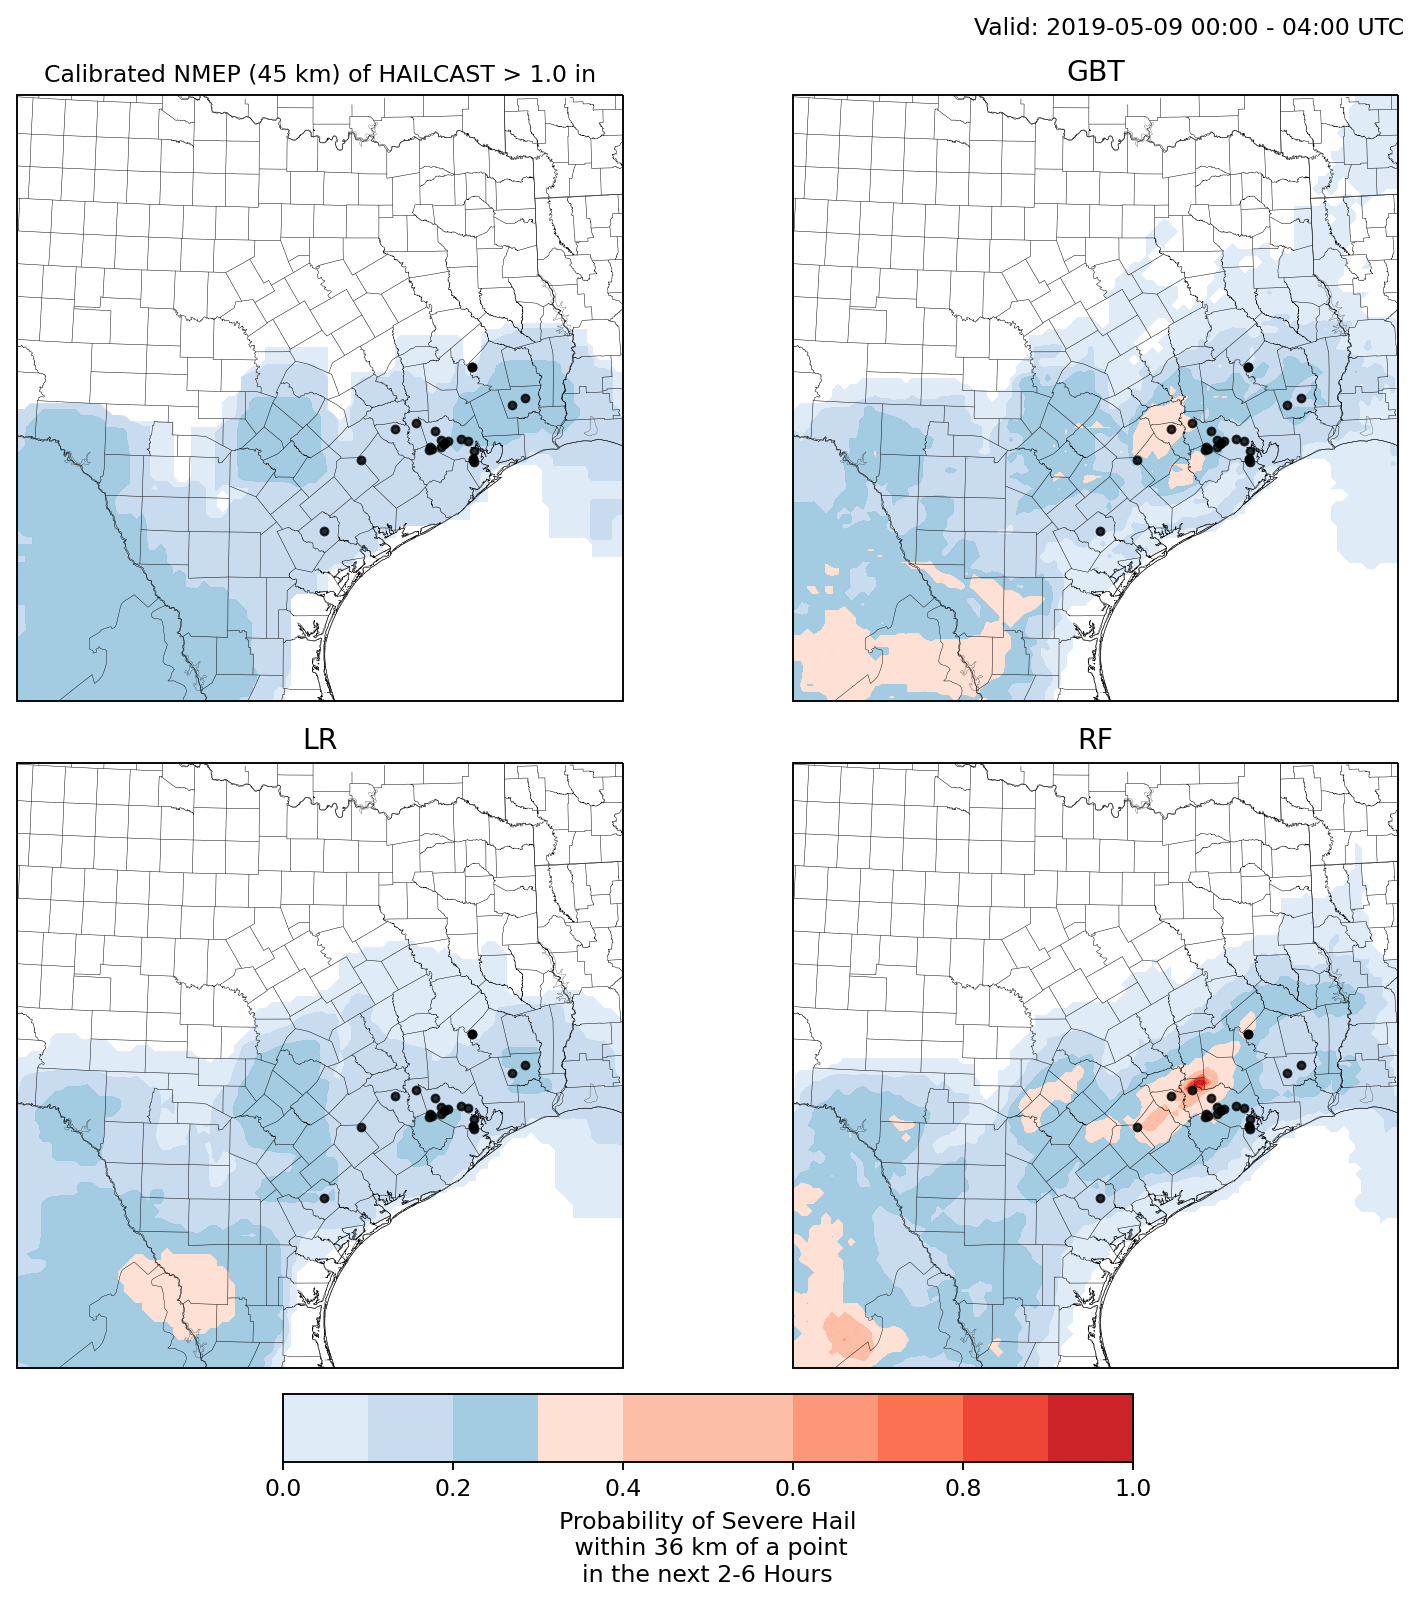

In [155]:
%matplotlib inline

hazard_color = {'hail' : 'g', 'wind': 'b', 'tornado': 'r'}
fig, axes = plt.subplots(figsize=(10,8), facecolor='w',
                     dpi=170, nrows=2, ncols=2, subplot_kw={'projection': projection}, 
                        constrained_layout=True)

models = ['BL', 'hist', 'logistic', 'random']
model_names = [baseline_names[hazard], 'GBT', 'LR', 'RF']

if hazard != 'tornado':
    levels = np.arange(0, 1.1, 0.1)
else:
    levels = np.arange(0, 0.5, 0.001)

# All 3 Models and BL
for ax, model, name in zip(axes.flat, models, model_names):
    if model == 'BL':
        pred = get_bl_pred(X_bl, shape, hazard, scale)
    else:
        pred = get_ml_pred(X, shape, hazard, scale, model)
    
    add_map_stuff(ax, states, shape_feature)
    pred = np.ma.masked_where(pred<=0.025, pred)
    
    #cmap=WoFSColors.wz_cmap
    cf = ax.contourf(lons,lats, pred, cmap=WoFSColors.wz_cmap, alpha=0.95, levels=levels,
                transform = crs, )

    ##point_lat, point_lon = points[hazard]
    _points = points[hazard]
    ax.scatter(_points[:,1],_points[:,0], s=10, color='k', alpha=0.8, zorder=1, transform=crs)
    
    ax = set_extent(ax, projection , crs, lats, lons,)
    fontsize = 10 if len(name) > 5 else 12
    ax.set_title(name, fontsize=fontsize)

fig.tight_layout()
#plt.subplots_adjust(hspace=0.2, wspace=0.0)
axes[0,1].annotate(title, (0.3, 1.1), xycoords='axes fraction', fontsize=10, color='k')

cax = fig.add_axes([0.25, -0.05, 0.5, 0.05])

fig.colorbar(cf, 
           cax=cax, 
           label=f'Probability of {titles[hazard]}\n within 36 km of a point\nin the next 2-6 Hours', 
          orientation='horizontal')

In [156]:
#check different scales of target/features, check the optimization pickle